In [26]:
# "The social benefits of emotion variability"
# Analysis script for Study 5 
# Evan W. Carr, 05-02-2018 (Columbia Business School)

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

from plotnine import *
from rpy2.robjects import r, pandas2ri

%matplotlib inline

# Set working directory to location of data files, and read in .csv's:
rawData = pd.read_csv("manic8_exptrun_final_clean_18_05_02.csv")
rawDemog = pd.read_csv("demographics_survey_survey_18_05_02.csv")

rawData.head(20)

,date,time,group,subject,build,blocknum,trialnum,blockcode,trialcode,pretrialpause,...,latency,stimulusnumber1,stimulusitem1,stimulusonset1,stimulusnumber2,stimulusitem2,stimulusonset2,stimulusnumber3,stimulusitem3,stimulusonset3
0,50118,12:17:12,591177365,89191249,5.0.11.0,1,1,expt_intro,expt_intro,0,...,44428,1,"Welcome to the study! During this session, ...",1,1,cbs_logo.jpg,1,1,"If you need to exit the study early, you can d...",1
1,50118,12:17:12,591177365,89191249,5.0.11.0,2,1,lvpos_block_female,lvpos_trial_female,0,...,500,53,WF-011_11.jpg,0,0,0,0,0,0,0
2,50118,12:17:12,591177365,89191249,5.0.11.0,2,2,lvpos_block_female,lvpos_trial_female,0,...,500,48,WF-011_11.jpg,0,0,0,0,0,0,0
3,50118,12:17:12,591177365,89191249,5.0.11.0,2,3,lvpos_block_female,lvpos_trial_female,0,...,500,43,WF-011_11.jpg,0,0,0,0,0,0,0
4,50118,12:17:12,591177365,89191249,5.0.11.0,2,4,lvpos_block_female,lvpos_trial_female,0,...,500,46,WF-011_09.jpg,0,0,0,0,0,0,0
5,50118,12:17:12,591177365,89191249,5.0.11.0,2,5,lvpos_block_female,lvpos_trial_female,0,...,500,57,WF-011_10.jpg,0,0,0,0,0,0,0
6,50118,12:17:12,591177365,89191249,5.0.11.0,2,6,lvpos_block_female,lvpos_trial_female,0,...,500,51,WF-011_09.jpg,0,0,0,0,0,0,0
7,50118,12:17:12,591177365,89191249,5.0.11.0,2,7,lvpos_block_female,lvpos_trial_female,0,...,500,49,WF-011_12.jpg,0,0,0,0,0,0,0
8,50118,12:17:12,591177365,89191249,5.0.11.0,2,8,lvpos_block_female,lvpos_trial_female,0,...,500,41,WF-011_09.jpg,0,0,0,0,0,0,0
9,50118,12:17:12,591177365,89191249,5.0.11.0,2,9,lvpos_block_female,lvpos_trial_female,0,...,500,60,WF-011_13.jpg,0,0,0,0,0,0,0


In [27]:
# All subjects should have 266 observations (rows) in the dataset ...
# Any that don't have 266 did not finish the study, and need to be removed before analysis:
rawObsCount = rawData.groupby('subject', as_index=False).size().reset_index(name='counts')
rawObsCount.sort_values(by='counts').head(15)

,subject,counts
3,32073609,22
86,490314937,56
32,224996053,79
134,858139380,111
13,89191249,112
62,400254029,133
105,668798529,266
106,669969665,266
107,671285698,266
108,679899236,266


In [28]:
# Create list of subject ID's to exclude (subjects that don't have 266 observations):
exclSbj = rawObsCount.query('counts != 266')
exclSbj = np.array(exclSbj['subject'])
exclSbj

array([ 32073609,  89191249, 224996053, 400254029, 490314937, 532438726,
       858139380], dtype=int64)

In [29]:
# Filter to important columns, and exclude subjects that didn't finish the study:
cleanCols = ['subject', 'blocknum', 'trialnum', 'blockcode', 'trialcode', 'response', 'latency', 'stimulusitem1']
cleanData = rawData.loc[~rawData['subject'].isin(exclSbj)][cleanCols]
cleanData.head()

,subject,blocknum,trialnum,blockcode,trialcode,response,latency,stimulusitem1
247,873239814,1,1,expt_intro,expt_intro,57.0,24697,"Welcome to the study! During this session, ..."
248,873239814,2,1,lvneg_block_male,lvneg_trial_male,0.0,500,WM-029_-12_crop.jpg
249,873239814,2,2,lvneg_block_male,lvneg_trial_male,0.0,500,WM-029_-13_crop.jpg
250,873239814,2,3,lvneg_block_male,lvneg_trial_male,0.0,500,WM-029_-13_crop.jpg
251,873239814,2,4,lvneg_block_male,lvneg_trial_male,0.0,500,WM-029_-11_crop.jpg


In [30]:
# Quickly check subject times to complete the study (should usually be between 4-8 minutes):
completionTimes = cleanData.groupby('subject').agg({'latency': 'sum'}).reset_index()
completionTimes['latency_mins'] = (completionTimes['latency'] / 1000) / 60
completionTimes.head(10)

,subject,latency,latency_mins
0,19040938,492421,8.207017
1,22365250,334687,5.578117
2,25665793,244186,4.069767
3,35596804,329982,5.499700
4,41586819,312557,5.209283
5,42844292,280479,4.674650
6,78732617,517848,8.630800
7,82619709,548385,9.139750
8,82927329,297364,4.956067
9,83603297,298910,4.981833


In [31]:
# Get quick demographics summary, without excluded subjects:
demogSummary = rawDemog.groupby('subject').agg({'age_response': np.mean, "gender_response": pd.Series.unique}).reset_index()
demogSummary = demogSummary[~demogSummary['subject'].isin(exclSbj)]

demogSummary['age_response'].mean()

36.254901960784316

In [32]:
demogSummary['age_response'].std()

12.403060642949928

In [33]:
demogSummary['gender_response'].value_counts()

Female    95
Male      58
Name: gender_response, dtype: int64

In [34]:
# Create column for emotion variability condition ('model_block'):
cleanData = cleanData.join(cleanData['blockcode'].str.split('_', 1, expand=True).rename(columns={0:'model_block', 1:'junk'}))
cleanData = cleanData.drop(['junk'], axis=1)
cleanData.head()
cleanData['model_block'].unique()

array(['expt', 'lvneg', 'hvneut', 'hvneg', 'hvpos', 'lvneut', 'lvpos'], dtype=object)

In [35]:
# Map emotion variability condition ('model_block') to umbrella factor: 
varDict = {'expt': 'expt',
           'lvneg': 'lv',
           'lvneut': 'lv',
           'lvpos': 'lv',
           'hvneg': 'hv',
           'hvneut': 'hv',
           'hvpos': 'hv'}

valenceDict = {'expt': 'expt',
               'lvneg': 'neg',
               'lvneut': 'neut',
               'lvpos': 'pos',
               'hvneg': 'neg',
               'hvneut': 'neut',
               'hvpos': 'pos'}

cleanData['model_block_valence'] = cleanData['model_block'].map(valenceDict)
cleanData['model_block_variability'] = cleanData['model_block'].map(varDict)

cleanData.head()

,subject,blocknum,trialnum,blockcode,trialcode,response,latency,stimulusitem1,model_block,model_block_valence,model_block_variability
247,873239814,1,1,expt_intro,expt_intro,57.0,24697,"Welcome to the study! During this session, ...",expt,expt,expt
248,873239814,2,1,lvneg_block_male,lvneg_trial_male,0.0,500,WM-029_-12_crop.jpg,lvneg,neg,lv
249,873239814,2,2,lvneg_block_male,lvneg_trial_male,0.0,500,WM-029_-13_crop.jpg,lvneg,neg,lv
250,873239814,2,3,lvneg_block_male,lvneg_trial_male,0.0,500,WM-029_-13_crop.jpg,lvneg,neg,lv
251,873239814,2,4,lvneg_block_male,lvneg_trial_male,0.0,500,WM-029_-11_crop.jpg,lvneg,neg,lv


In [36]:
# Access and log stimulus model ID codes for inclusion in mixed-effects models (shown later):
ratingsList = ['authenticity_slider', 'unfriendliness_slider']
modelSummary = cleanData.groupby(['subject', 'blocknum']).agg({"stimulusitem1": pd.Series.unique}).reset_index()

modelSummary.head(10)

,subject,blocknum,stimulusitem1
0,19040938,1,"Welcome to the study! During this session, ..."
1,19040938,2,"[WF-016_-20.jpg, WF-016_-09.jpg, WF-016_-08.jp..."
2,19040938,3,"[WM-016_-03_crop.jpg, WM-016_02_crop.jpg, WM-0..."
3,19040938,4,"[WF-003_neutral.jpg, WF-003_-02.jpg, WF-003_03..."
4,19040938,5,"[WM-029_13_crop.jpg, WM-029_12_crop.jpg, WM-02..."
5,19040938,6,"[WF-009_-11.jpg, WF-009_-12.jpg, WF-009_-09.jp..."
6,19040938,7,"[WF-015_10.jpg, WF-015_09.jpg, WF-015_13.jpg, ..."
7,19040938,8,"[WM-009_10_crop.jpg, WM-009_09_crop.jpg, WM-00..."
8,19040938,9,"[WM-033_-10_crop.jpg, WM-033_-11_crop.jpg, WM-..."
9,19040938,10,"[WF-027_03.jpg, WF-027_15.jpg, WF-027_06.jpg, ..."


In [37]:
# 'modelSummary' dataframe shows all unique stimuli shown to each subject, by blocknum ...
# Not useful yet, but will be if we can split stimulus names apart:
modelList = []
for i in range(0, modelSummary.shape[0]):
    modelID = modelSummary.iloc[i]['stimulusitem1'][0].split('_', 1)[0]
    modelList.append(modelID)
    
modelSummary['model_id'] = modelList
modelSummary = modelSummary.drop('stimulusitem1', axis=1)

modelSummary.head(10)

,subject,blocknum,model_id
0,19040938,1,W
1,19040938,2,WF-016
2,19040938,3,WM-016
3,19040938,4,WF-003
4,19040938,5,WM-029
5,19040938,6,WF-009
6,19040938,7,WF-015
7,19040938,8,WM-009
8,19040938,9,WM-033
9,19040938,10,WF-027


In [38]:
# Subjects only saw real stimuli in blocknum's 2-7 ...
# Do an inner join with the main data to get only those blocks, then filter to only when subjects gave ratings:
cleanRatings = pd.merge(cleanData, modelSummary, on=('subject', 'blocknum'), how='inner')
cleanRatings = cleanRatings.loc[(cleanRatings['model_block'] != 'expt') & (cleanRatings['trialcode'].isin(ratingsList)), :]
cleanRatings = cleanRatings.drop(['blocknum', 'trialnum', 'blockcode', 'stimulusitem1'], axis=1)

cleanRatings.head(40)

,subject,trialcode,response,latency,model_block,model_block_valence,model_block_variability,model_id
21,873239814,authenticity_slider,38.0,7986,lvneg,neg,lv,WM-029
22,873239814,unfriendliness_slider,36.0,5892,lvneg,neg,lv,WM-029
43,873239814,unfriendliness_slider,35.0,6933,hvneut,neut,hv,WM-009
44,873239814,authenticity_slider,72.0,2887,hvneut,neut,hv,WM-009
65,873239814,authenticity_slider,66.0,3848,hvneut,neut,hv,WF-027
66,873239814,unfriendliness_slider,19.0,5285,hvneut,neut,hv,WF-027
87,873239814,unfriendliness_slider,80.0,4661,hvneg,neg,hv,WM-016
88,873239814,authenticity_slider,33.0,3432,hvneg,neg,hv,WM-016
109,873239814,authenticity_slider,31.0,8143,hvneg,neg,hv,WF-015
110,873239814,unfriendliness_slider,85.0,3531,hvneg,neg,hv,WF-015


In [39]:
# Create individual datasets for each major DV:
authenticityData = cleanRatings.query("trialcode == 'authenticity_slider'")
unfriendlinessData = cleanRatings.query("trialcode == 'unfriendliness_slider'")

In [40]:
# Run mixed-effects models on each DV:
#    - fixed = variability (high vs. low) & valence (negative vs. neutral vs. positive)
#    - random = subject_id & model_id

# Push objects to R to start analyses ...
# (statsmodels package in python has trouble fitting certain random-effect structures):

pandas2ri.activate()
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [41]:
# Send datasets with ratings to R: 
%R -i authenticityData,unfriendlinessData

In [42]:
%%R

# Use R to create mixed-effects models with both subject- and stimulus-level random effects:

library(lmerTest)

a_m1 <- lmer(response ~ model_block_valence * model_block_variability + (1|subject) + (1|model_id), data=authenticityData)
a_m1_anova <- anova(a_m1)
a_m1_lsmeans <- lsmeans(a_m1)
a_m1_difflsmeans <- difflsmeans(a_m1)
             
u_m1 <- lmer(response ~ model_block_valence * model_block_variability + (1|subject) + (1|model_id), data=unfriendlinessData)
u_m1_anova <- anova(u_m1)
u_m1_lsmeans <- lsmeans(u_m1)
u_m1_difflsmeans <- difflsmeans(u_m1)

In [43]:
# Pull model results back to python:
%R -o a_m1_anova,a_m1_lsmeans,a_m1_difflsmeans,u_m1_anova,u_m1_lsmeans,u_m1_difflsmeans

In [44]:
# On authenticity, both main effects are significant, but no interaction:
pandas2ri.ri2py(a_m1_anova)

,Sum Sq,Mean Sq,NumDF,DenDF,F.value,Pr(>F)
model_block_valence,61660.149847,30830.074924,2,1670.476235,64.168782,0.000000
model_block_variability,5733.745207,5733.745207,1,1670.847312,11.934043,0.000565
model_block_valence:model_block_variability,502.461004,251.230502,2,1670.129580,0.522904,0.592894


In [45]:
# For unfriendliness, both main effects are significant, with marginal interaction:
pandas2ri.ri2py(u_m1_anova)

,Sum Sq,Mean Sq,NumDF,DenDF,F.value,Pr(>F)
model_block_valence,349176.557376,174588.278688,2,1669.492607,353.788460,0.000000
model_block_variability,9270.498117,9270.498117,1,1669.764264,18.785885,0.000015
model_block_valence:model_block_variability,2713.578677,1356.789339,2,1669.231225,2.749419,0.064255


In [46]:
# Where are the differences for authenticity?
pandas2ri.ri2py(a_m1_difflsmeans[0])

,Estimate,Standard Error,DF,t-value,Lower CI,Upper CI,p-value
model_block_valence neg - neut,-4.6668,1.2558,1669.7,-3.72,-7.1299,-2.2036,0.0002
model_block_valence neg - pos,-13.9805,1.2561,1669.9,-11.13,-16.4442,-11.5169,0.0000
model_block_valence neut - pos,-9.3138,1.2582,1671.8,-7.40,-11.7816,-6.8459,0.0000
model_block_variability hv - lv,3.5458,1.0264,1670.8,3.45,1.5326,5.5591,0.0006
model_block_valence:model_block_variability neg hv - neut hv,-5.4416,1.7749,1669.0,-3.07,-8.9230,-1.9603,0.0022
model_block_valence:model_block_variability neg hv - pos hv,-13.4800,1.7745,1668.7,-7.60,-16.9605,-9.9996,0.0000
model_block_valence:model_block_variability neg hv - neg lv,3.3629,1.7771,1670.4,1.89,-0.1226,6.8485,0.0586
model_block_valence:model_block_variability neg hv - neut lv,-0.5290,1.7756,1669.5,-0.30,-4.0117,2.9538,0.7658
model_block_valence:model_block_variability neg hv - pos lv,-11.1181,1.7800,1672.1,-6.25,-14.6094,-7.6268,0.0000
model_block_valence:model_block_variability neut hv - pos hv,-8.0384,1.7744,1668.6,-4.53,-11.5187,-4.5581,0.0000


In [47]:
# What about for unfriendliness?
pandas2ri.ri2py(u_m1_difflsmeans[0])

,Estimate,Standard Error,DF,t-value,Lower CI,Upper CI,p-value
model_block_valence neg - neut,14.5204,1.2729,1668.9,11.41,12.0237,17.0170,0.0000
model_block_valence neg - pos,33.7629,1.2732,1669.1,26.52,31.2658,36.2601,0.0000
model_block_valence neut - pos,19.2426,1.2755,1670.5,15.09,16.7409,21.7443,0.0000
model_block_variability hv - lv,-4.5096,1.0404,1669.8,-4.33,-6.5503,-2.4689,0.0000
model_block_valence:model_block_variability neg hv - neut hv,14.1557,1.7990,1668.4,7.87,10.6272,17.6843,0.0000
model_block_valence:model_block_variability neg hv - pos hv,31.0147,1.7985,1668.2,17.24,27.4871,34.5423,0.0000
model_block_valence:model_block_variability neg hv - neg lv,-6.5848,1.8013,1669.4,-3.66,-10.1179,-3.0518,0.0003
model_block_valence:model_block_variability neg hv - neut lv,8.3002,1.7998,1668.7,4.61,4.7701,11.8302,0.0000
model_block_valence:model_block_variability neg hv - pos lv,29.9263,1.8045,1670.7,16.58,26.3871,33.4656,0.0000
model_block_valence:model_block_variability neut hv - pos hv,16.8590,1.7984,1668.2,9.37,13.3315,20.3864,0.0000


In [48]:
# Prep lists of estimates and SEM's for plot dataframe:
estimateList1 = [pandas2ri.ri2py(a_m1_lsmeans[0]).Estimate[5:11],
                pandas2ri.ri2py(u_m1_lsmeans[0]).Estimate[5:11]]
estimateList2 = []

semList1 = [pandas2ri.ri2py(a_m1_lsmeans[0])['Standard Error'][5:11],
            pandas2ri.ri2py(u_m1_lsmeans[0])['Standard Error'][5:11]]
semList2 = []

for sublist in estimateList1:
    for item in sublist:
        estimateList2.append(item)
        
for sublist in semList1:
    for item in sublist:
        semList2.append(item)

In [49]:
# Create dataset for plotting:
plotData = pd.DataFrame({
    'rating_type': ['Authenticity']*6 + ['Unfriendliness']*6,
    'valence': ['Negative', 'Neutral', 'Positive', 'Negative', 'Neutral', 'Positive']*2,
    'variability': ['High Variability', 'High Variability', 'High Variability',
                    'Low Variability', 'Low Variability', 'Low Variability']*2, 
    'slider_mean': estimateList2,
    'slider_sem': semList2
})

plotData

,rating_type,slider_mean,slider_sem,valence,variability
0,Authenticity,55.0332,1.8066,Negative,High Variability
1,Authenticity,60.4749,1.8065,Neutral,High Variability
2,Authenticity,68.5133,1.8061,Positive,High Variability
3,Authenticity,51.6703,1.8071,Negative,Low Variability
4,Authenticity,55.5622,1.8073,Neutral,Low Variability
5,Authenticity,66.1514,1.8094,Positive,Low Variability
6,Unfriendliness,59.3227,2.0478,Negative,High Variability
7,Unfriendliness,45.1670,2.0477,Neutral,High Variability
8,Unfriendliness,28.3080,2.0473,Positive,High Variability
9,Unfriendliness,65.9075,2.0482,Negative,Low Variability


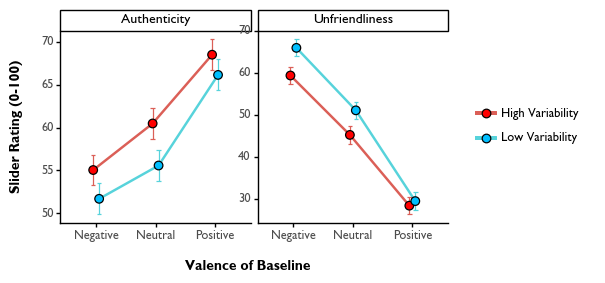

<ggplot: (132720118413)>

In [50]:
# Use plotnine package to plot using ggplot2 (R) style ...
(ggplot(plotData, aes(x='valence', y='slider_mean', fill='variability', group='variability', color='variability'))
 + geom_line(size=1, position=position_dodge(0.2))
 + geom_errorbar(aes(ymin='slider_mean-slider_sem', ymax='slider_mean+slider_sem', color='variability'), width=0.15, position=position_dodge(0.2))
 + geom_point(shape='o', color='black', size=3, stroke=0.5, position=position_dodge(0.2), alpha=1)
 + scale_fill_manual(values=["red", "deepskyblue"])
 + facet_wrap('~rating_type', scales='free_y', nrow=1, ncol=2)
 + labs(y='Slider Rating (0-100)\n', x='\nValence of Baseline') 
 + theme_classic()
 + theme(figure_size = (5, 2.5),
         text = element_text(family='Gill Sans MT'), 
         axis_text_x = element_text(size=9), 
         axis_text_y = element_text(size=9), 
         axis_title_x = element_text(weight='bold', size=10), 
         axis_title_y = element_text(weight='bold', size=10),
         axis_line_y = element_line(color='black'),
         legend_title = element_blank(),
         legend_text = element_text(size=9),
         legend_position = 'right',
         strip_background = element_rect(fill='white'),
         strip_text_x = element_text(size=10, color='black'))) 
  